# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
>
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [17]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change).
    They are parallel and located at opposite ends of the frame.
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.

In [18]:
l=0.5
r=0.125

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

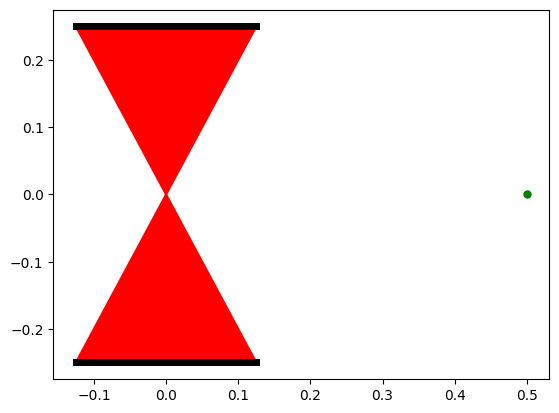

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import math

def draw_scooter(x, y, theta):
    alpha=np.arctan(l/(2*r))
    beta = np.pi-2*alpha
    t=r/np.cos(alpha)

    # Calculate the coordinates of the triangle
    base1_x = t*np.cos(theta-(beta/2)+np.pi/2)
    base1_y = t*np.sin(theta-beta/2+np.pi/2)
    base2_x= t*np.cos(theta+beta/2+np.pi/2)
    base2_y= t*np.sin(theta+beta/2+np.pi/2)


    # Plot the triangle
    plt.plot([x,x+base1_x,x+base2_x,x], [y,y+base1_y,y+base2_y,y], 'r-')
    plt.plot([x,x-base1_x,x-base2_x,x], [y,y-base1_y,y-base2_y,y], 'r-')

    #plot the wheels

    plt.plot([x-base1_x,x-base2_x], [y-base1_y,y-base2_y], 'k-', linewidth=5)
    plt.plot([x+base1_x,x+base2_x], [y+base1_y,y+base2_y], 'k-', linewidth=5)

    plt.plot(x+0.5*np.cos(theta), y+0.5*np.sin(theta), 'go', markersize=5)

    plt.fill([x,x+base1_x,x+base2_x,x], [y,y+base1_y,y+base2_y,y], 'r-')
    plt.fill([x,x-base1_x,x-base2_x,x], [y,y-base1_y,y-base2_y,y], 'r-')

# Example usage
draw_scooter(0, 0, 0)


🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [82]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)


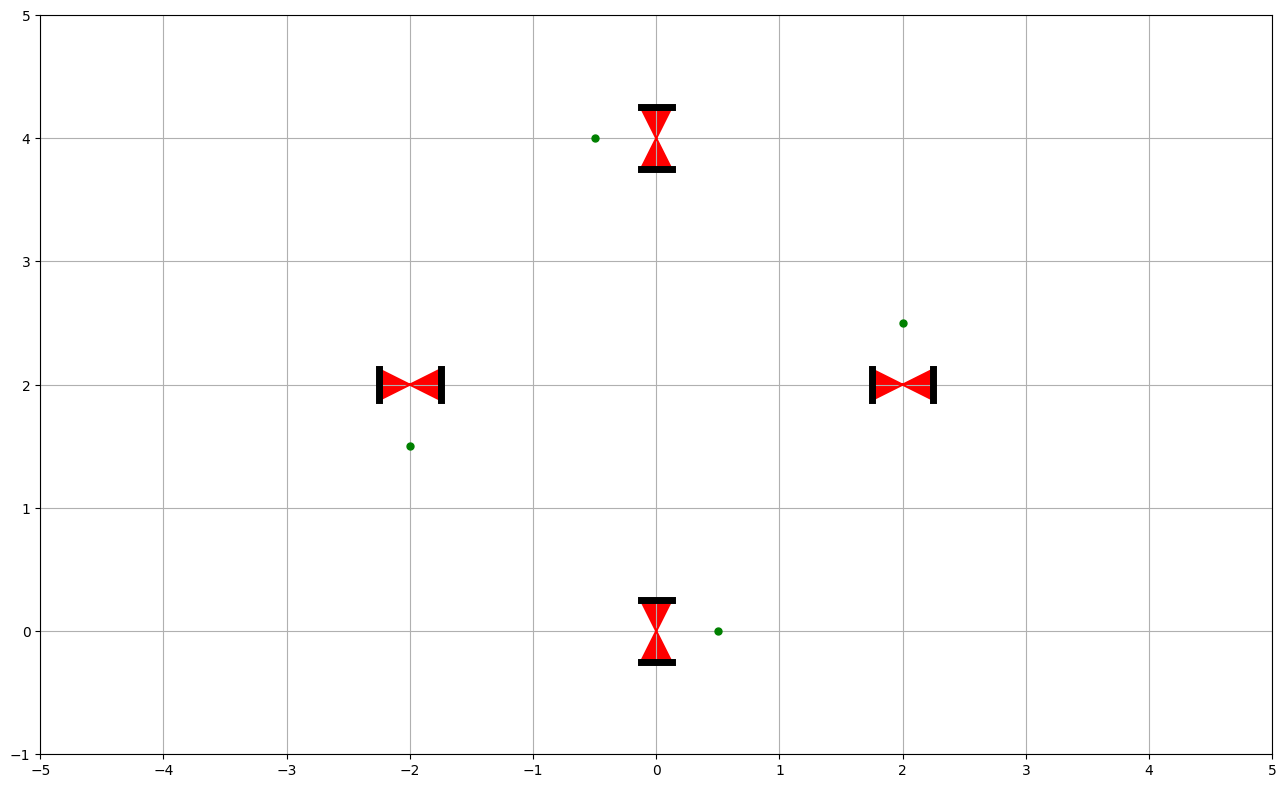

In [83]:
draw_arena(-5, 5, -1, 5)
draw_scooter(0, 0, 0)
draw_scooter(2, 2, np.pi/2)
draw_scooter(0, 4, np.pi)
draw_scooter(-2, 2, 3*np.pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping.

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

**Answer**

La vitesse linéaire 𝑣 du centre de l'axe de la roue est la moyenne des vitesses linéaires des deux roues :
$ v = \frac{r}{2} (\omega_l + \omega_r)$

La vitesse angulaire du scooter est déterminée par la différence des vitesses des deux roues :
$\dot{\theta} = \frac{r}{l} (\omega_r - \omega_l)$

Ensuite, nous décomposons la vitesse linéaire 𝑣 en ses composantes 𝑥 et 𝑦 en fonction de l'angle d'orientation 𝜃:
$\dot{x} = v \cos(\theta) = \frac{r}{2} (\omega_l + \omega_r) \cos(\theta)$  et  
$\dot{y} = v \sin(\theta) = \frac{r}{2} (\omega_l + \omega_r) \sin(\theta)$


Équations Différentielles
En combinant ces composantes, nous obtenons le système d'équations différentielles :

$\dot{x} = \frac{r}{2} (\omega_l + \omega_r) \cos(\theta) $

$\dot{y} = \frac{r}{2} (\omega_l + \omega_r) \sin(\theta) $

$\dot{\theta} = \frac{r}{l} (\omega_r - \omega_l) $


**TODO**

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

**Answer**

Existence des Solutions

L'existence de solutions peut être établie en remarquant que le côté droit de chaque équation différentielle est continu et différentiable par rapport à x,y et $\ \theta $, le côté droit des équations différentielles est également continu et différentiable.

Unicité des Solutions

Pour démontrer l'unicité, on utilise le théorème de Picard-Lindelöf, également connu sous le nom de théorème d'existence et d'unicité pour les équations différentielles ordinaires. Ce théorème stipule que si le côté droit des équations différentielles est Lipschitz continu par rapport aux variables dépendantes, alors il existe une solution unique pour toute condition initiale.

Dans notre cas, le côté droit des équations différentielles est Lipschitz continu car tous les termes impliquant Wl et Wr sont linéaires. Par conséquent, le système a une solution unique pour toute condition initiale.

Conclusion

Puisque le système d'équations différentielles décrivant le mouvement du scotter a une solution unique pour toute condition initiale, il est bien posé. Ceci est vrai pour toute fonction continûment différentiable Wl et Wr, y compris le cas des entrées constantes.


**TODO**

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**Answer**

Lorsque Wr et Wl sont constants,le système d'équations différentielles a une solution unique pour toute condition initiale, comme démontré précédemment. Puisque Wr et Wl sont constants, les trajectoires de solution sont déterminées uniquement par la condition initiale et les valeurs constantes de Wl et Wr. Par conséquent, la solution maximale associée à toute condition initiale est globale.

Lorsque Wl et Wr sont des fonctions arbitrairement continûment dérivables, le système d'équations différentielles reste bien posé, comme démontré précédemment. Cependant, l'existence et l'unicité globales de la solution maximale ne sont pas garanties dans ce cas.
Wr et Wl sont des fonctions arbitraires, le comportement du système pourrait devenir plus complexe, pouvant entraîner des situations où les trajectoires de solution divergent ou s'intersectent. Cela signifie que pour certaines conditions initiales, il pourrait ne pas exister de solution maximale unique s'étendant pour tout temps.

En résumé, bien que le système reste bien posé lorsque
sont des fonctions arbitrairement continûment dérivables, l'existence et l'unicité globales de la solution maximale ne sont pas garanties dans ce cas.

**TODO**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [23]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [24]:
def fun(t,xytheta):
  theta=xytheta[2]
  omega_l=omega(t, xytheta)[0]
  omega_r=omega(t, xytheta)[1]
  x_p=(r/2)*(omega_l+omega_r)*cos(theta)
  y_p=(r/2)*(omega_l+omega_r)*sin(theta)
  theta_p=(r/l)*(omega_r - omega_l)
  return array([x_p, y_p, theta_p])


### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [72]:
from scipy.integrate import solve_ivp

# Initial state
x0, y0, theta0 = 0.0, 0.0, 0.0

# Solve the differential equations using solve_ivp
solution = solve_ivp(fun, [0, 4], [x0, y0, theta0], dense_output=True)

# Generate dense output
t_dense = np.linspace(0, 4, 100)
xytheta_dense = solution.sol(t_dense)

# Extract positions and orientations
x_dense, y_dense, theta_dense = xytheta_dense[0], xytheta_dense[1], xytheta_dense[2]

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

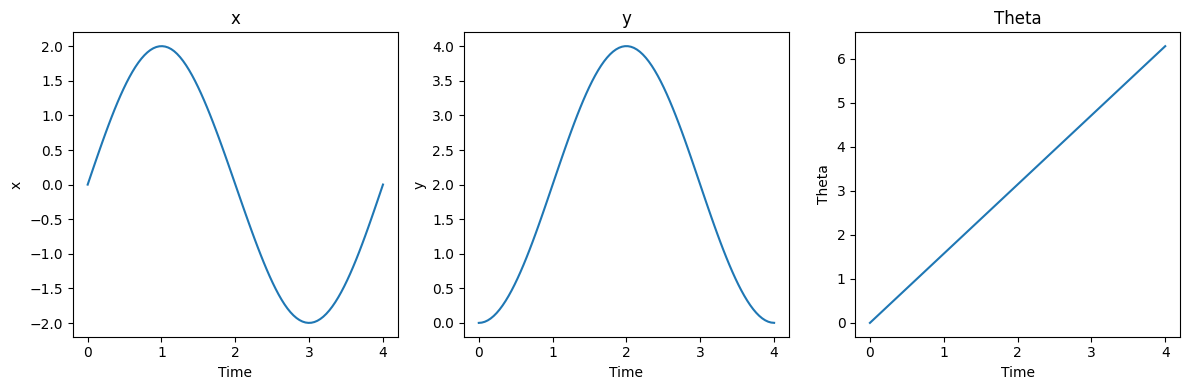

In [73]:
import matplotlib.pyplot as plt

# Plot the positions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t_dense, x_dense)
plt.xlabel('Time')
plt.ylabel('x')
plt.title('x')

plt.subplot(1, 3, 2)
plt.plot(t_dense, y_dense)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('y')

plt.subplot(1, 3, 3)
plt.plot(t_dense, theta_dense)
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Theta')

plt.tight_layout()
plt.show()


🧩 Use the simulation results to display the robot location every 0.5 second.

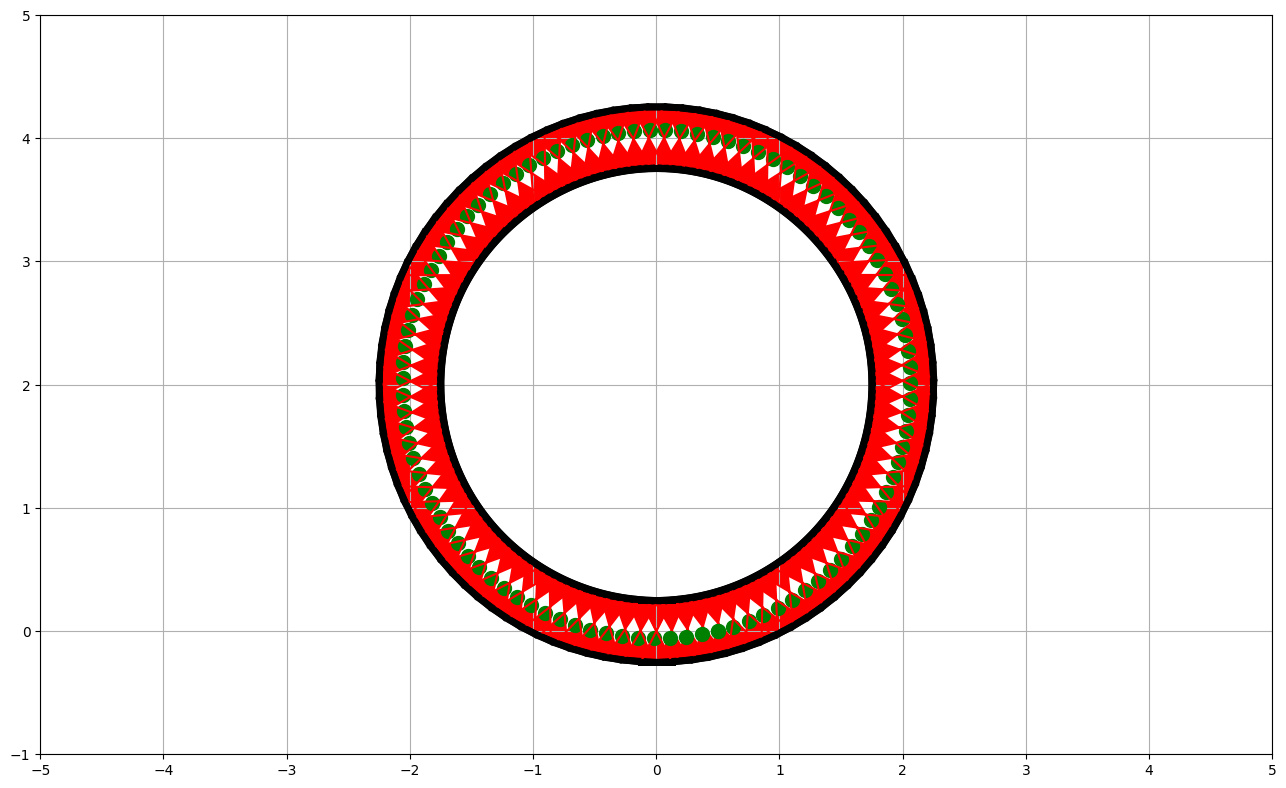

In [74]:
draw_arena(-5, 5, -1, 5)
for i in range (len(x_dense)):
    draw_scooter(x_dense[i],y_dense[i],theta_dense[i])

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$?

**Answer**

Les équations différentielles déjà obtenues pour $\dot{x}$, $\dot{y}$ et $\dot{\theta}$ :

$\dot{x} = \frac{r}{2} (\omega_l + \omega_r) \cos(\theta) $

$\dot{y} = \frac{r}{2} (\omega_l + \omega_r) \sin(\theta) $

$\dot{\theta} = \frac{r}{l} (\omega_r - \omega_l) $

Comme $\omega_l$ et $\omega_r$ sont constantes, on intègre ces 3 dernières équations pour déteminer les expressions analytiques de ${x}$, ${y}$ et ${\theta}$. On obtient les expressions suivantes:

${x}(t) = \frac{l}{2} \frac{(\omega_l + \omega_r)}{(\omega_r - \omega_l)} \sin(\theta) $

${y}(t) = \frac{l}{2} \frac{(\omega_l + \omega_r)}{(\omega_r - \omega_l)} (1-\cos(\theta)) $

${\theta}(t) = \frac{r}{l} (\omega_r - \omega_l)*t $

**TODO**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

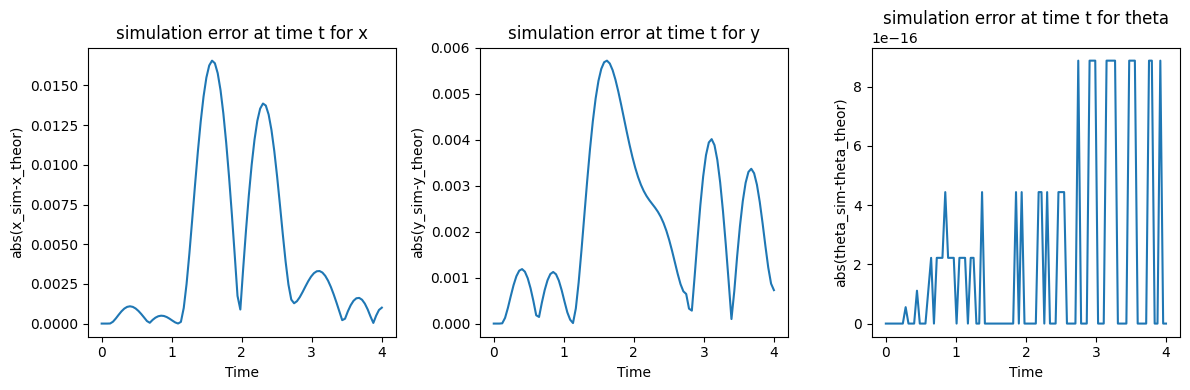


 Experimental results match the theoretical results for x, y and theta with an error less than 1 mm for theta and with an error of max 20 mm for x and y


In [75]:
omega_l = (1 - l/4) * np.pi / r
omega_r = (1 + l/4) * np.pi / r
theta=(r/l)*(omega_r-omega_l)*t_dense
x=(l/2)*((omega_l+omega_r)/(omega_r-omega_l))*sin(theta)
y=(l/2)*((omega_l+omega_r)/(omega_r-omega_l))*(1-cos(theta))
import matplotlib.pyplot as plt

# Plot the positions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t_dense, abs(x_dense-x))
plt.xlabel('Time')
plt.ylabel('abs(x_sim-x_theor)')
plt.title('simulation error at time t for x')

plt.subplot(1, 3, 2)
plt.plot(t_dense, abs(y_dense-y))
plt.xlabel('Time')
plt.ylabel('abs(y_sim-y_theor)')
plt.title('simulation error at time t for y')

plt.subplot(1, 3, 3)
plt.plot(t_dense, abs(theta_dense-theta))
plt.xlabel('Time')
plt.ylabel('abs(theta_sim-theta_theor)')
plt.title('simulation error at time t for theta')

plt.tight_layout()
plt.show()
print("\n Experimental results match the theoretical results for x, y and theta with an error less than 1 mm for theta and with an error of max 20 mm for x and y")

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$.

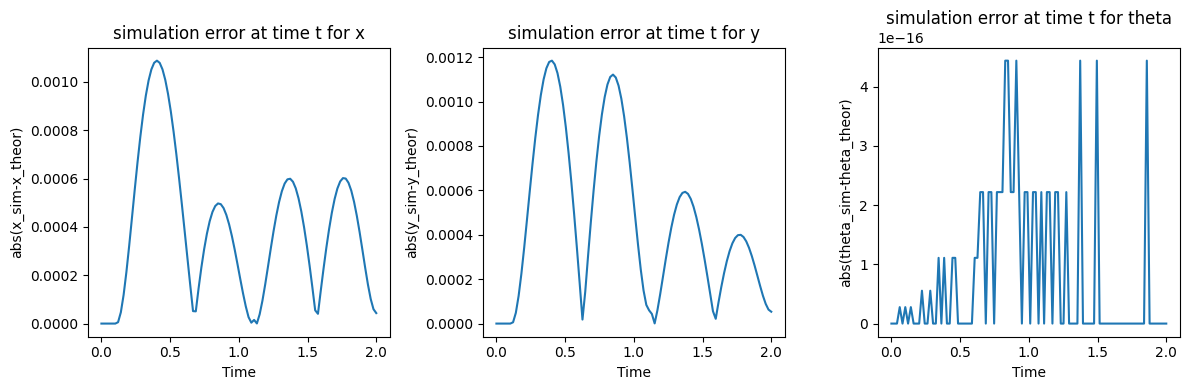


 Experimental results match the theoretical results for x, y and theta with an error less than 1 mm after changing the simulation time from 4 secs to 2 secs 


In [78]:
#on change la durée de simulation de 4 à 2 secondes
# Initial state
x0, y0, theta0 = 0.0, 0.0, 0.0

# Solve the differential equations using solve_ivp
solution = solve_ivp(fun, [0, 2], [x0, y0, theta0], dense_output=True)

# Generate dense output
t_dense = np.linspace(0, 2, 100)
xytheta_dense = solution.sol(t_dense)

# Extract positions and orientations
x_dense, y_dense, theta_dense = xytheta_dense[0], xytheta_dense[1], xytheta_dense[2]
omega_l = (1 - l/4) * np.pi / r
omega_r = (1 + l/4) * np.pi / r
theta=(r/l)*(omega_r-omega_l)*t_dense
x=(l/2)*((omega_l+omega_r)/(omega_r-omega_l))*sin(theta)
y=(l/2)*((omega_l+omega_r)/(omega_r-omega_l))*(1-cos(theta))
import matplotlib.pyplot as plt

# Plot the positions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t_dense, abs(x_dense-x))
plt.xlabel('Time')
plt.ylabel('abs(x_sim-x_theor)')
plt.title('simulation error at time t for x')

plt.subplot(1, 3, 2)
plt.plot(t_dense, abs(y_dense-y))
plt.xlabel('Time')
plt.ylabel('abs(y_sim-y_theor)')
plt.title('simulation error at time t for y')

plt.subplot(1, 3, 3)
plt.plot(t_dense, abs(theta_dense-theta))
plt.xlabel('Time')
plt.ylabel('abs(theta_sim-theta_theor)')
plt.title('simulation error at time t for theta')

plt.tight_layout()
plt.show()
print("\n Experimental results match the theoretical results for x, y and theta with an error less than 1 mm after changing the simulation time from 4 secs to 2 secs ")